# 1 Load the Data

In [146]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import mplleaflet

# The Data is part of the Kaggle Competition: https://www.kaggle.com/c/sf-crime/data
df_base = pd.read_csv("data/sf-crime/train.csv")

print(df_base.describe())
df_base.head()

                   X              Y
count  878049.000000  878049.000000
mean     -122.422616      37.771020
std         0.030354       0.456893
min      -122.513642      37.707879
25%      -122.432952      37.752427
50%      -122.416420      37.775421
75%      -122.406959      37.784369
max      -120.500000      90.000000


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


# 2 Explore the Data

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]),
 <a list of 39 Text xticklabel objects>)

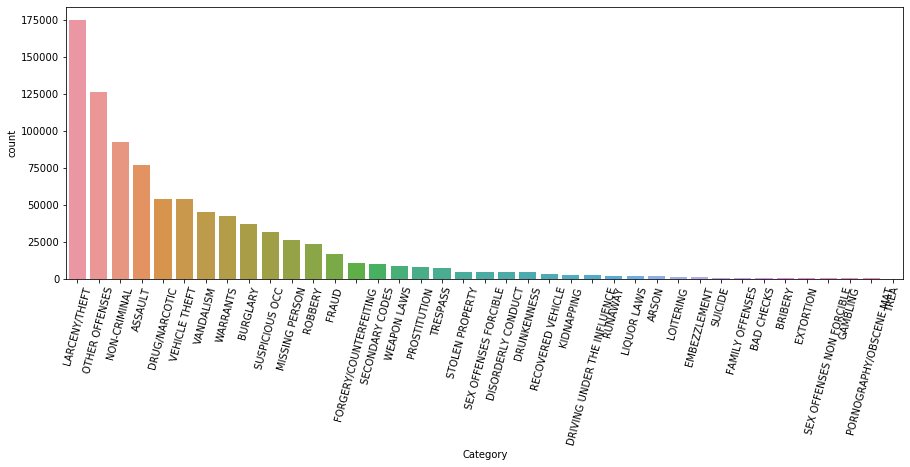

In [77]:
# print the value counts of the categories
plt.figure(figsize=(15,5))
sns.countplot(x = df_base['Category'], orient='v', order = df_base['Category'].value_counts().index)
plt.xticks(rotation=75)

(array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.,
        140000., 160000.]),
 <a list of 9 Text xticklabel objects>)

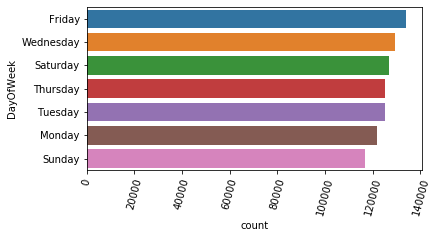

In [78]:
# Print Crime Counts per Weekday
plt.figure(figsize=(6,3))
sns.countplot(y = df_base['DayOfWeek'], orient='h', order = df_base['DayOfWeek'].value_counts().index)
plt.xticks(rotation=75)

<Figure size 1152x720 with 0 Axes>

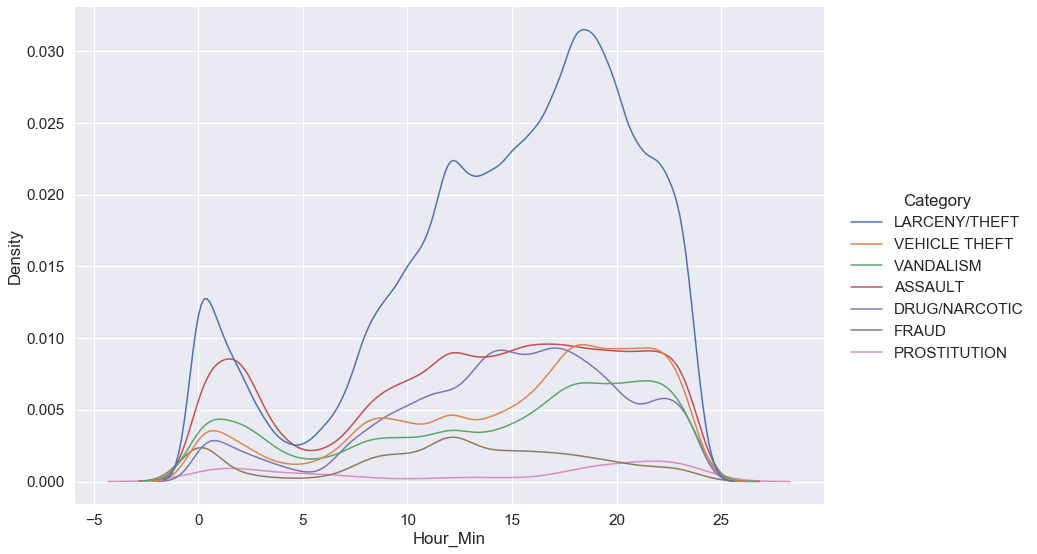

<Figure size 1152x720 with 0 Axes>

In [123]:
# Convert the time to minutes
df_base['Hour_Min'] = pd.to_datetime(df_base['Dates']).dt.hour  + pd.to_datetime(df_base['Dates']).dt.minute / 60

# Print Crime Counts per Time and Category
df_base_filtered = df_base[df_base['Category'].isin([
    'PROSTITUTION', 
    'VEHICLE THEFT', 
    'DRUG/NARCOTIC', 
    'WARRENTS', 
    'BURGLERY', 
    'FRAUD', 
    'ASSAULT',
    'LARCENY/THEFT',
    'VANDALISM'])]

sns.displot(x = 'Hour_Min', hue="Category", data = df_base_filtered, kind="kde", height=8, aspect=1.5)
plt.figure(figsize=(16,10))

In [80]:
# let's explore what information we can extract from the streetnames
for i in df_base['Address'][0:10]:
    print(i)

OAK ST / LAGUNA ST
OAK ST / LAGUNA ST
VANNESS AV / GREENWICH ST
1500 Block of LOMBARD ST
100 Block of BRODERICK ST
0 Block of TEDDY AV
AVALON AV / PERU AV
KIRKWOOD AV / DONAHUE ST
600 Block of 47TH AV
JEFFERSON ST / LEAVENWORTH ST


# 3 Data Preprocessing

In [130]:
# Processing Function for Features
def cart2polar(x, y):
    dist = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return dist, phi

def preprocessFeatures(dfx):
    
    # Time Feature Engineering
    df = pd.get_dummies(dfx[['DayOfWeek' , 'PdDistrict']])
    df['Hour_Min'] = pd.to_datetime(dfx['Dates']).dt.hour + pd.to_datetime(dfx['Dates']).dt.minute / 60
    # We add a feature that contains the expontential time
    df['Hour_Min_Exp'] = np.exp(df['Hour_Min'])
    
    df['Day'] = pd.to_datetime(dfx['Dates']).dt.day
    df['Month'] = pd.to_datetime(dfx['Dates']).dt.month
    df['Year'] = pd.to_datetime(dfx['Dates']).dt.year

    month_one_hot_encoded = pd.get_dummies(pd.to_datetime(dfx['Dates']).dt.month, prefix='Month')
    df = pd.concat([df, month_one_hot_encoded], axis=1, join="inner")
    
    # Convert Carthesian Coordinates to Polar Coordinates
    df[['X', 'Y']] = dfx[['X', 'Y']] # we maintain the original coordindates as additional features
    df['dist'], df['phi'] = cart2polar(dfx['X'], dfx['Y'])
  
    # Extracting Street Types
    df['Is_ST'] = dfx['Address'].str.contains(" ST", case=True)
    df['Is_AV'] = dfx['Address'].str.contains(" AV", case=True)
    df['Is_WY'] = dfx['Address'].str.contains(" WY", case=True)
    df['Is_TR'] = dfx['Address'].str.contains(" TR", case=True)
    df['Is_DR'] = dfx['Address'].str.contains(" DR", case=True)
    df['Is_Block'] = dfx['Address'].str.contains(" Block", case=True)
    df['Is_crossing'] = dfx['Address'].str.contains(" / ", case=True)
    
    return df

# Processing Function for Labels
def encodeLabels(dfx):
    df = pd.DataFrame (columns = [])
    factor = pd.factorize(dfx['Category'])
    return factor

# Remove Outliers by Longitude
df_cleaned = df_base[df_base['Y']<70]

# Encode Labels as Integer
factor = encodeLabels(df_cleaned)
y_df = factor[0]
labels = list(factor[1])
# for val, i in enumerate(labels):
#     print(val, i)

# 4 Visualize the Data on a Map

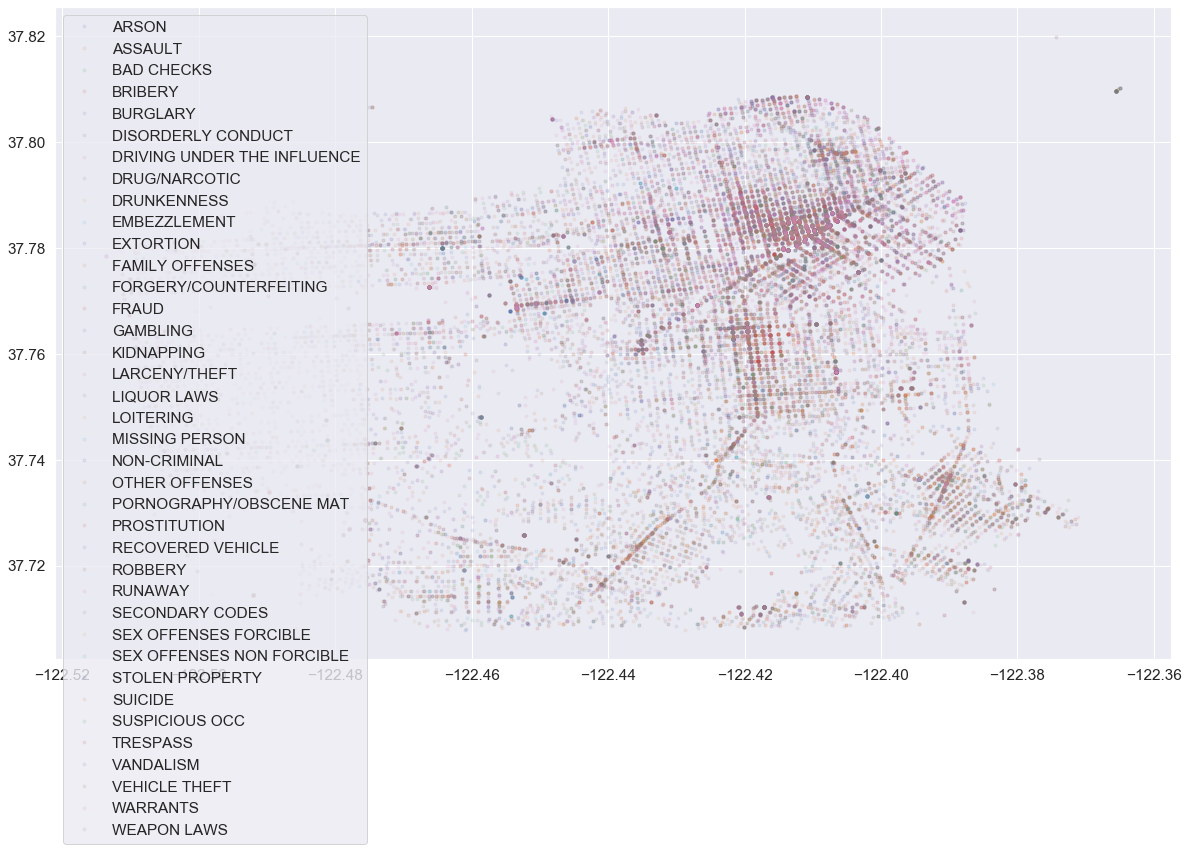

In [144]:
# Plot Criminal Activities by Lat and Long
df_filtered = df_cleaned.sample(frac=0.05)  
#df_filtered = df_cleaned[df_cleaned['Category'].isin(['PROSTITUTION', 'VEHICLE THEFT', 'FRAUD'])].sample(frac=0.05) # to filter 

groups = df_filtered.groupby('Category')

fig, ax = plt.subplots(sharex=False, figsize=(20, 12))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['X'], group['Y'], marker='.', linestyle='', label=name, alpha=0.1)
ax.legend()
plt.show()

In [133]:
# Limit the data to a fraction and selected categories
df_filtered = df_cleaned.sample(frac=0.01) 
df_filtered = df_cleaned[df_cleaned['Category'].isin(['PROSTITUTION', 'VEHICLE THEFT', 'FRAUD'])].sample(frac=0.05) # to filter 

# Visualize Criminal Activities on a Geo Map
fig, ax = plt.subplots(sharex=False, figsize=(20, 10))
for name, group in groups:
    ax.plot(group['X'], group['Y'], marker='.', linestyle='', label=name)
mplleaflet.show()

# 5 Split the Data

In [131]:
# Create train_df & test_df
x_df = preprocessFeatures(df_cleaned).copy()

# Split the data into x_train and y_train data sets
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, train_size=0.7, random_state=0)
x_train.head()

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,...,Y,dist,phi,Is_ST,Is_AV,Is_WY,Is_TR,Is_DR,Is_Block,Is_crossing
276998,0,0,0,0,0,1,0,0,0,0,...,37.785023,128.110900,2.842200,True,False,False,False,False,True,False
81579,0,0,0,0,0,1,0,0,0,0,...,37.748470,128.185052,2.842677,False,True,False,False,False,True,False
206676,0,0,0,1,0,0,0,0,0,0,...,37.762744,128.113657,2.842389,True,False,False,False,False,True,False
732006,0,0,0,0,0,0,1,0,0,0,...,37.784140,128.109653,2.842204,True,False,False,False,False,False,True
796194,1,0,0,0,0,0,0,0,0,0,...,37.791333,128.125982,2.842185,True,False,False,False,False,True,False


# 6 Train a Random Decision Forest Classifier

In [153]:
# Train a single random forest classifier - parameters are a best guess
clf = RandomForestClassifier(max_depth=50, random_state=0, n_estimators = 100)
clf.fit(x_train, y_train.ravel())
y_pred = clf.predict(x_test)

results_log = classification_report(y_test, y_pred)
print(results_log)

              precision    recall  f1-score   support

           0       0.15      0.10      0.12     12657
           1       0.29      0.35      0.32     37898
           2       0.38      0.63      0.47     52237
           3       0.46      0.40      0.43     16136
           4       0.16      0.08      0.10     13426
           5       0.25      0.21      0.23     27798
           6       0.10      0.04      0.06      6850
           7       0.23      0.22      0.23     23087
           8       0.19      0.12      0.15      2586
           9       0.20      0.13      0.15     10942
          10       0.08      0.03      0.05      9559
          11       0.00      0.00      0.00      1300
          12       0.20      0.10      0.14      3200
          13       0.37      0.43      0.40     16282
          14       0.02      0.02      0.02      1350
          15       0.01      0.00      0.00      2912
          16       0.05      0.03      0.04      2217
          17       0.61    

# 7 Train an XGBoost Classifier

In [157]:
# Configure the XGBoost model
param = {'booster': 'gbtree', 
         'tree_method': 'gpu_hist',
         'predictor': 'gpu_predictor',
         'max_depth': 70, 
         'eta': 0.15, 
         'objective': '{multi:softmax}', 
         'eval_metric': 'rmse', #e.g., rmse, rmsle, auc, mae, mlogloss
         'num_round': 100,
         'feature_selector ': 'greedy', #cyclic, greedy, shuffle, random, thrifty
         'sampling_method': 'gradient_based'
        }

xgb_clf = XGBClassifier(param)
xgb_clf.fit(x_train, y_train.ravel())
score = xgb_clf.score(x_test, y_test.ravel())
print(score)

# Create predictions on the test dataset
y_pred = xgb_clf.predict(x_test)

# Print a classification report
results_log = classification_report(y_test, y_pred)
print(results_log)

[23:01:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.30852142219859907
              precision    recall  f1-score   support

           0       0.17      0.01      0.02     12657
           1       0.30      0.42      0.35     37898
           2       0.33      0.72      0.46     52237
           3       0.31      0.27      0.29     16136
           4       0.21      0.03      0.05     13426
           5       0.24      0.18      0.21     27798
           6       0.17      0.01      0.01      6850
           7       0.21      0.19      0.20     23087
           8       0.26      0.01      0.02      2586
           9       0.22      0.08      0.12     10942
          10       0.13      0.00      0.00      9559
          11       0

# 8 Visualize Model Performance

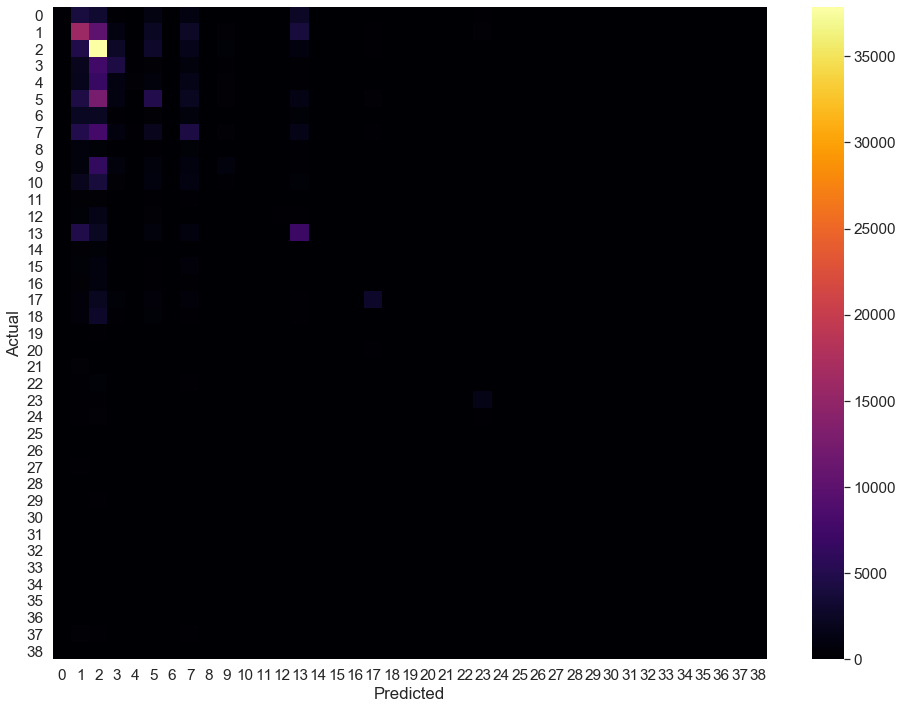

In [138]:
# Print a multi-Class Confusion Matrix
cnf_matrix = confusion_matrix(y_test.reshape(-1), y_pred)
df_cm = pd.DataFrame(cnf_matrix, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (16,12))
plt.tight_layout()
sns.set(font_scale=1.4) #for label size
sns.heatmap(df_cm, cbar=True, cmap= "inferno", annot=False, fmt='.0f' #, annot_kws={"size": 13}
           )